In [108]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 12

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

# for hierarchy part
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [4]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

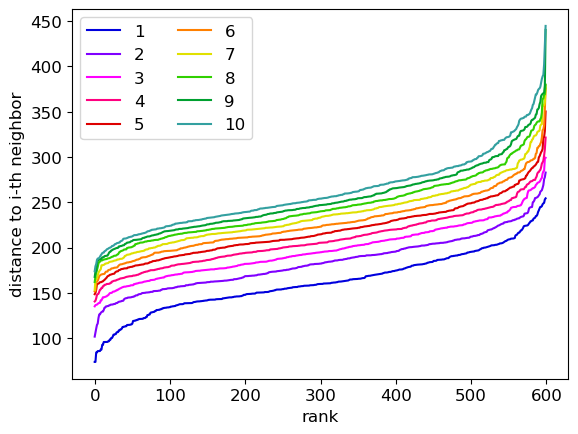

mean minimum distance between points:  162.34622464324366


In [5]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)

## t-SNE visualization, for true labels

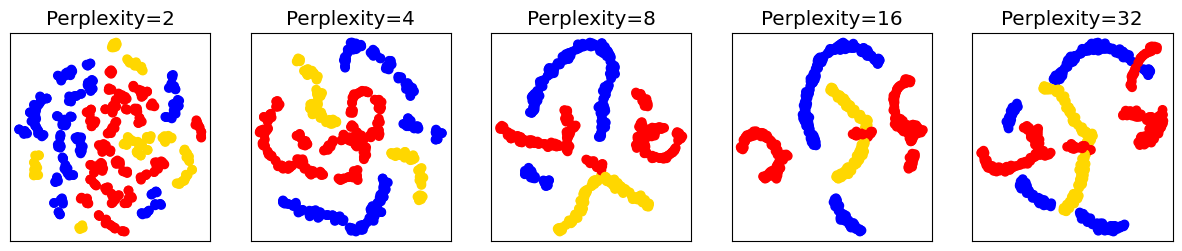

In [6]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

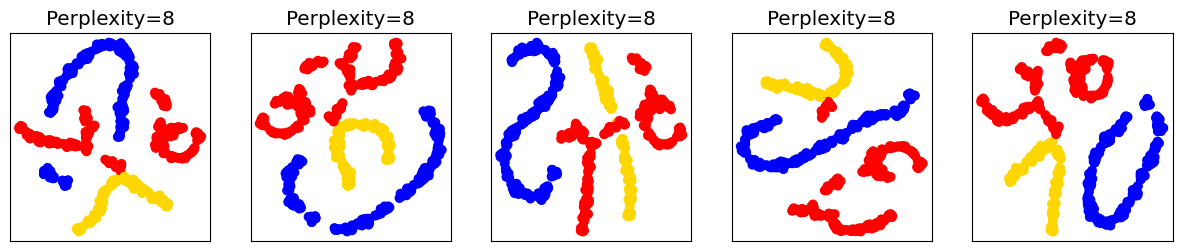

In [7]:
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',random_state=i, 
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

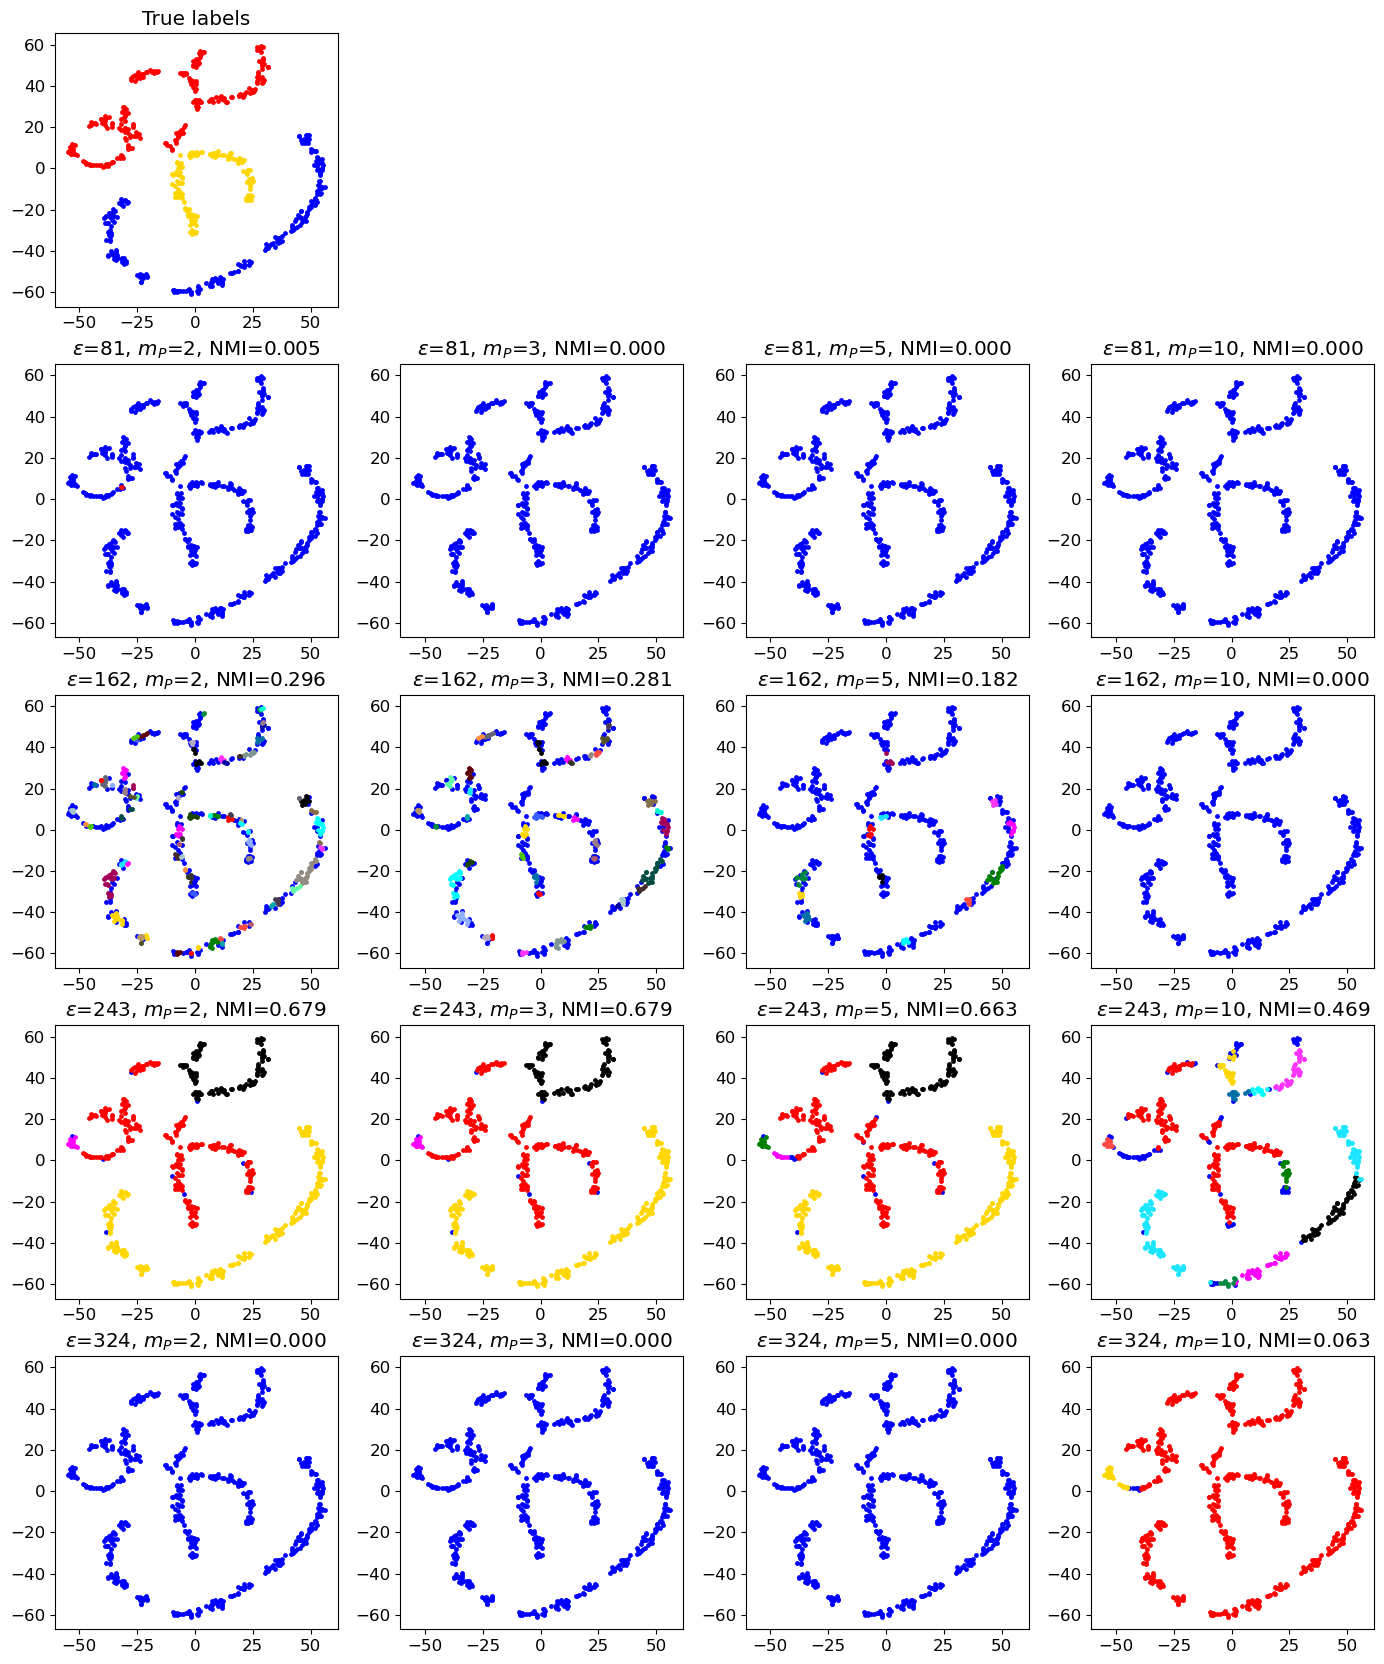

In [91]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax, colors=None):
    # plotting function
    if colors==None:
        col = False
    else:
        col = True
        colors = np.array(colors)
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        if col == False:
            ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)
        else:
    
            ax.scatter(X[pos,0], X[pos,1],c=colors[pos],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r,1.5*r,2*r]

min_sample_range = [2,3,5,10]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(14,16.8))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()


# 1. “eps” (ε) and “minPts” (mP) in DBSCAN algorithm for clustering

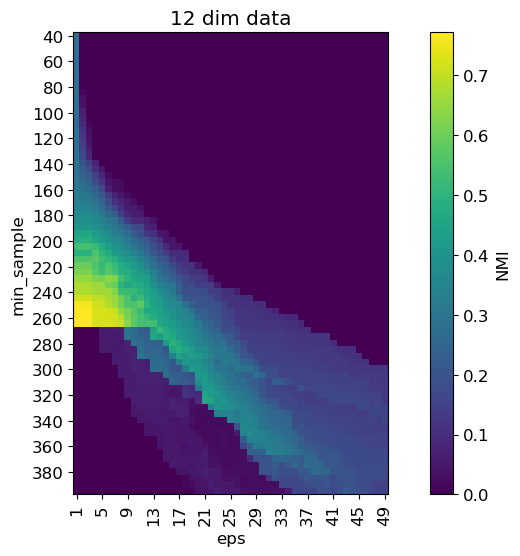

In [67]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = range(40,400,5)

min_sample_range = range(1,50)
DIMY=len(eps_range)
DIMX=len(min_sample_range)

i,j=0,0
nmi=1

nmi_array = []

for i, eps in enumerate(eps_range):
    nmi_row = []
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi=NMI(y_hat, y_true)
        nmi_row.append(nmi)
    nmi_array.append(nmi_row)

plt.figure(figsize = (11,6))

plt.imshow(nmi_array, cmap='viridis', interpolation='nearest')
plt.colorbar(label="NMI", shrink= 1)
plt.yticks(range(len(eps_range)), labels=eps_range)
plt.xticks(range(len(min_sample_range)), labels=min_sample_range, rotation = 90)
xticks = plt.xticks()[0] 
yticks = plt.yticks()[0]

plt.xticks(xticks[::4])
plt.yticks(yticks[::4])

plt.xlabel("eps")
plt.ylabel("min_sample")
plt.grid(visible=False)
plt.title("12 dim data")
plt.show()

Looking at the map we can observe a correlation between the $\epsilon$ and the minimum number of neighboor ($m_p$) used to identify a cluster. In particular we can see that there is a region of high value of NMI for which appear a direct correlation between $m_p$ used to define the cluster and the dimension of the hyper-sphere $\epsilon$.

We can perform a fit to have a rule to calculate the best value of $\epsilon$ given $m_p$.

# 2. Understanding the 12-dimensional data

The 1° component given by PCA is the 1, it count for the 65.13% of the variability
The 2° component given by PCA is the 2, it count for the 27.66% of the variability
The 3° component given by PCA is the 3, it count for the 7.07% of the variability
The 4° component given by PCA is the 4, it count for the 0.07% of the variability
The 5° component given by PCA is the 5, it count for the 0.02% of the variability
The 6° component given by PCA is the 6, it count for the 0.02% of the variability
The 7° component given by PCA is the 7, it count for the 0.01% of the variability
The 8° component given by PCA is the 10, it count for the 0.01% of the variability
The 9° component given by PCA is the 11, it count for the 0.01% of the variability
The 10° component given by PCA is the 12, it count for the 0.00% of the variability
The 11° component given by PCA is the 9, it count for the 0.00% of the variability
The 12° component given by PCA is the 8, it count for the 0.00% of the variability




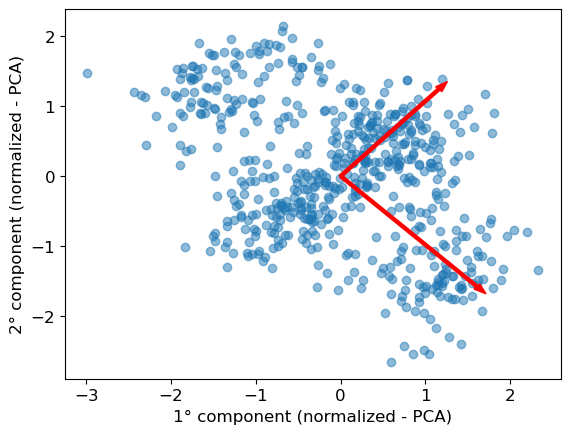

In [68]:
#Rescaling the data
me = np.mean(data,axis = 0)
dev = np.std(data,axis = 0)

data_sc = (data - me) / dev

C = np.cov(data_sc.T)

val, vec = np.linalg.eig(C)
sorted_indices = np.argsort(val)[::-1]
val = val[sorted_indices]
vec = vec[:, sorted_indices]

nrm = np.linalg.norm(val)**2

for i in range(len(val)):
    print(f"The {i+1}° component given by PCA is the {sorted_indices[i]+1}, it count for the {val[i]**2/nrm*100 :.2f}% of the variability")

plt.scatter(data_sc[:,sorted_indices[0]],data_sc[:,sorted_indices[1]], alpha=0.5)
factor = 200
for i in range(2):  # First two components
    plt.arrow(0, 0, vec[0, i] * val[i], vec[1, i] * val[i], color='red', width=0.04, head_width=0.1, alpha=1)

print("\n")
plt.xlabel("1° component (normalized - PCA)")
plt.ylabel("2° component (normalized - PCA)")
plt.show()

# 3. Compare with k-means

### Define k-means function

In [69]:
def kmeans(points: np.ndarray, k: int, max_iters: int = 50):
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # Generate random centroids
    # Use the correct means and standard deviation to ensure they represent the whole input space
    point_count = points.shape[0]
    coord_count = points.shape[1]
    data_means=[0]*coord_count
    data_devs=[0]*coord_count
    for coord in range(coord_count):
        data_means[coord] = np.mean(points[:,coord])
        data_devs[coord] = np.std(points[:,coord])

    centroids = np.ndarray((k,coord_count))
    for num_centroid in range(k):
        for coord in range(coord_count):
            centroids[num_centroid, coord] = np.random.normal(data_means[coord], data_devs[coord])

    clusters = np.ndarray((point_count,))
    
    prev_error = 1e9+1
    error = [1e9]
    
    # Iterate until the estimate of centroid is stable (or the maximum number of iterations is reached)
    iters = 0
    while (error[iters] != prev_error) and iters < max_iters:
        # Measure the distance to every centroid
        distances = np.ndarray((point_count,k))
        for point_num in range(point_count):
            for centroid_num in range(k):
                distances[point_num, centroid_num]=np.linalg.norm(points[point_num]-centroids[centroid_num])

        # Step 1: assign training data to closest centroid
        for point_num in range(point_count):
            clusters[point_num] = np.argmin(distances[point_num])
       
        # Calculate barycenter for every cluster and update the centroid
        for centroid_num in range(k):
            for coord_num in range(coord_count):
                sum_for_avg = 0
                count_for_avg = 0
                for point_num in range(point_count):
                    if(clusters[point_num] == centroid_num):
                        count_for_avg += 1
                        sum_for_avg += points[point_num, coord_num]
                #max is here to avoid sporadic "division by 0" errors
                centroids[centroid_num, coord_num] = sum_for_avg/np.max([count_for_avg, 1]) 
               
        
        # Update the error
        prev_error = error[iters]
        current_error = 0 # average L2 loss
        for point_num in range(point_count):
            distances = [0]*coord_count
            for coord_num in range(coord_count):
                distances[coord_num] = points[point_num, coord_num] - centroids[int(clusters[point_num]), coord_num]
            current_error+=np.sum(np.square(distances))
        current_error /= point_count
        error.append(current_error)
        
        # Update the iteration counter
        iters += 1

    return centroids, clusters, error

### Applyed to all 12 dimensions

In [70]:
_, y_k_means, _ = kmeans(data, k=3, max_iters = 50)

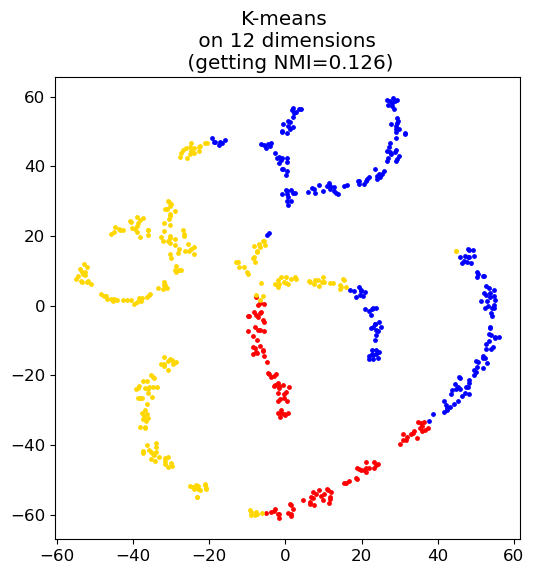

In [92]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

plotting_ax(X2D,y_k_means,ax)
nmi_k_means=NMI(y_k_means, y_true)
ax.set_title(f'K-means \n on 12 dimensions \n (getting NMI={nmi_k_means:.3f})')
plt.show()

### Applied just to the 2 chosen dimensions

In [122]:
centroids , y_k_means2D, _ = kmeans(X2D, k=3, max_iters = 50)

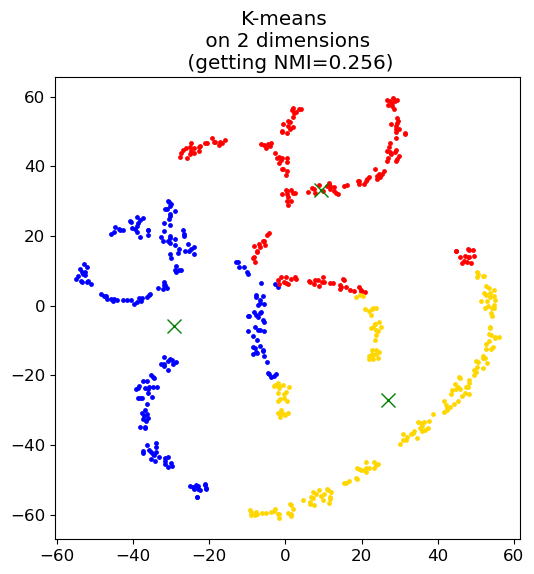

In [123]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

plotting_ax(X2D,y_k_means2D,ax)
nmi_k_means2D=NMI(y_k_means2D, y_true)
ax.set_title(f'K-means \n on 2 dimensions \n (getting NMI={nmi_k_means2D:.3f})')
ax.plot(centroids[:,0],centroids[:,1],"x",color="green",markersize=10)
plt.show()

### Comment

We had runned K-means algorithm both in all 12 dimensions of the input dataset, and in the 2 chosen projection dimensions.
Since the data are not well separated with respect to the classic euclidian distances K-means fails in the clustering task both consering all coordinates or just the 2 chosen; it is clearly visible by looking at the plot and by the very low NMI obtained.

# 4. Hierarchical clustering

### Define the Hierarchical function

In [129]:
def hierarc(dataset, n_clusters, linkage, plot_dendr=False):

    # To standardize data
    #scaler = StandardScaler()
    #data = scaler.fit_transform(data)

    hc = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    y_hierar = hc.fit_predict(dataset)

    if plot_dendr:
        plt.figure(figsize=(8, 6))
        linkage_matrix = sch.linkage(data, method=linkage)
        dendrogram = sch.dendrogram(linkage_matrix, color_threshold=linkage_matrix[-(n_clusters-1), 2])
        plt.title(f"Dendogram of Hierarchical Clustering")
        plt.xlabel("Index of data")
        plt.ylabel("Distance")
        plt.tick_params(       # to remove the x ticks, we used the following settings
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        plt.show()

    # following part just to be consistent with choice of the colors for the clusters
    '''
    cluster_colors = {}
    i = 0
    for label, color in zip(dendrogram['leaves'], dendrogram['leaves_color_list']):
        if label not in cluster_colors:
            cluster_colors[label] = color
    i += 1
    point_colors = [cluster_colors[label] for label in labels]
    '''
    leaf_colors = {}
    for leaf, color in zip(dendrogram['leaves'], dendrogram['leaves_color_list']):
        leaf_colors[leaf] = color
    point_colors = [leaf_colors[i] for i in range(len(labels))]

    return y_hierar, point_colors

### Applyed to all 12 dimensions

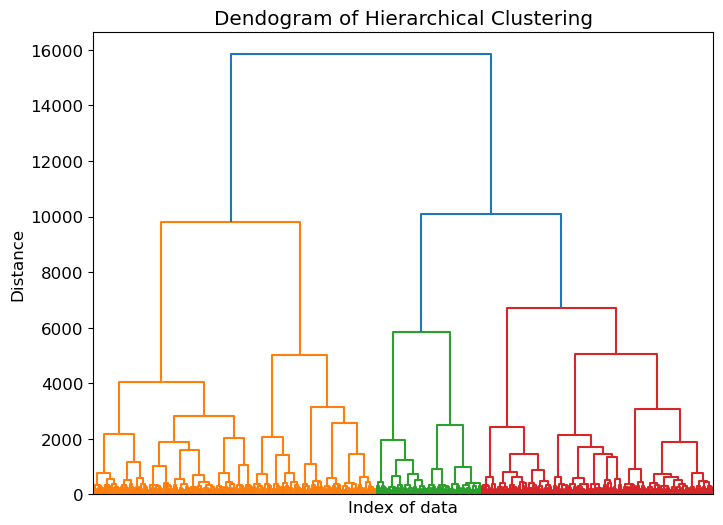

In [130]:
hierar_num_clust = 3
y_hierar, clusters_colors_hier = hierarc(dataset=data, n_clusters=hierar_num_clust, linkage='ward', plot_dendr=True)

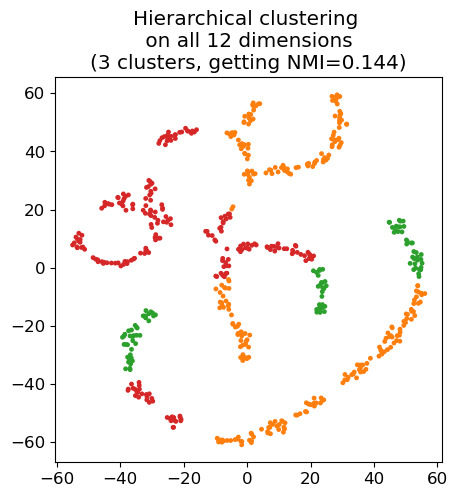

In [131]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

plotting_ax(X2D,y_hierar,ax,clusters_colors_hier)

nmi_hierar=NMI(y_hierar, y_true)
ax.set_title(f'Hierarchical clustering \n on all 12 dimensions \n({hierar_num_clust} clusters, getting NMI={nmi_hierar:.3f})')
plt.show()

### Applied just to the 2 chosen dimensions

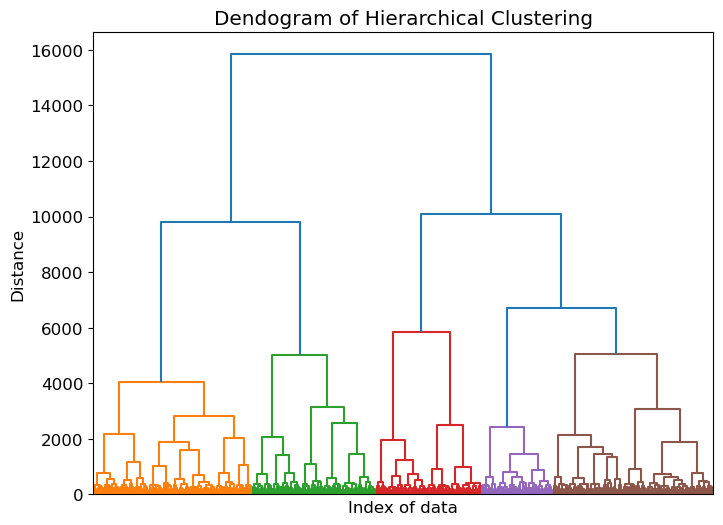

In [135]:
hierar_num_clust2D = 5
y_hierar2D, clusters_colors_hier2D = hierarc(dataset=X2D, n_clusters=hierar_num_clust2D, linkage='ward', plot_dendr=True)

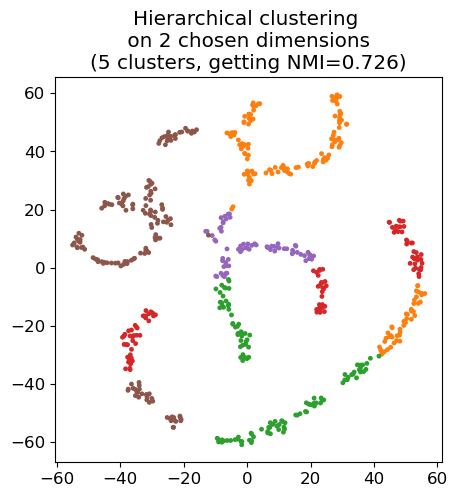

In [136]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

plotting_ax(X2D,y_hierar2D,ax,clusters_colors_hier2D)

nmi_hierar2D=NMI(y_hierar2D, y_true)
ax.set_title(f'Hierarchical clustering \n on 2 chosen dimensions \n({hierar_num_clust2D} clusters, getting NMI={nmi_hierar2D:.3f})')
plt.show()

### Comment

From the NMI we can see that hierarchical clustering works better focusing only on the 2 dimensions chosen with respect to apply this algorithm to all the dimensions. HO GIOCATO CON IL NUMERO DEI CLUSTER, VABBE' TUTTA DA FARE QUESTA PARTE PERO' ABBIAMO I TOOLS ORA

POI DA FARE QUESTO CHE DICE SOTTO PERCHE' I RISULTATI DI ORA SONO SOLO CON LINKAGE 'ward'

## QUELLO CHE CHIEDE DI FARE QUI

Which measure did you use for distance (distance of closest
points between clusters, distance between cluster centers, …)? Does it affect the result?

PER ME VUOL DIRE GIOCARE CON LA VARIABILE "linkage"
nella funzione
hierarc(dataset, n_clusters, linkage, plot_dendr=False)

oppure ho visto c'è un parametro chiamato

affinity (ad ex. 'euclidean'), che però mi dava problemi.

DA INDAGARE IN scipy.cluster.hierarchy.linkage

# 5. Visualize the data